In [35]:
from __future__ import division, print_function, absolute_import

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=False)

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from keras.datasets import mnist as mn
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from keras import backend as K
K.set_image_dim_ordering('th')

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [36]:
# Training Parameters
learning_rate = 0.01
num_steps = 500
batch_size = 128
n_images = 10000

# Network Parameters
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)
dropout = 0.25 # Dropout, probability to drop a unit

In [37]:
# Create the neural network
def conv_net(x_dict, n_classes, dropout, reuse, is_training):
    
    # Define a scope for reusing the variables
    with tf.variable_scope('ConvNet', reuse=reuse):
        # TF Estimator input is a dict, in case of multiple inputs
        x = x_dict['images']

        # MNIST data input is a 1-D vector of 784 features (28*28 pixels)
        # Reshape to match picture format [Height x Width x Channel]
        # Tensor input become 4-D: [Batch Size, Height, Width, Channel]
        x = tf.reshape(x, shape=[-1, 28, 28, 1])

        # Convolution Layer with 32 filters 
        conv1 = tf.layers.conv2d(x, 32, 5, activation=tf.nn.relu)

        # Convolution Layer with 64 filters 
        conv2 = tf.layers.conv2d(conv1, 64, 3, activation=tf.nn.relu)

        # Flatten the data to a 1-D vector for the fully connected layer
        fc1 = tf.contrib.layers.flatten(conv2)

        # Fully connected layer (in tf contrib folder for now)
        fc1 = tf.layers.dense(fc1, 1024)
        # Apply Dropout (if is_training is False, dropout is not applied)
        fc1 = tf.layers.dropout(fc1, rate=dropout, training=is_training)

        # Output layer, class prediction
        out = tf.layers.dense(fc1, n_classes)

    return out



In [38]:
# Define the model function (following TF Estimator Template)
def model_fn(features, labels, mode):
    
    # Build the neural network
    # Because Dropout have different behavior at training and prediction time, we
    # need to create 2 distinct computation graphs that still share the same weights.
    logits_train = conv_net(features, num_classes, dropout, reuse=False, is_training=True)
    logits_test = conv_net(features, num_classes, dropout, reuse=True, is_training=False)
    
    # Predictions
    pred_classes = tf.argmax(logits_test, axis=1)
    pred_probas = tf.nn.softmax(logits_test)
    
    # If prediction mode, early return
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode, predictions=pred_classes) 
        
    # Define loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits_train, labels=tf.cast(labels, dtype=tf.int32)))
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    train_op = optimizer.minimize(loss_op, global_step=tf.train.get_global_step())
    
    # Evaluate the accuracy of the model
    acc_op = tf.metrics.accuracy(labels=labels, predictions=pred_classes)
    
    # TF Estimators requires to return a EstimatorSpec, that specify
    # the different ops for training, evaluating, ...
    estim_specs = tf.estimator.EstimatorSpec(
      mode=mode,
      predictions=pred_classes,
      loss=loss_op,
      train_op=train_op,
      eval_metric_ops={'accuracy': acc_op})

    return estim_specs

In [39]:
# Build the Estimator
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpvru1_w3e', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x1c47cf3240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [40]:
# Evaluate the Model
# Define the input function for evaluating
input_fn = tf.estimator.inputs.numpy_input_fn(
    x={'images': mnist.test.images}, y=mnist.test.labels,
    batch_size=batch_size, shuffle=False)
# Use the Estimator 'evaluate' method
model.evaluate(input_fn)

INFO:tensorflow:Could not find trained model in model_dir: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpvru1_w3e, running initialization to evaluate.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-10-10-12:08:05
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-10-12:08:14
INFO:tensorflow:Saving dict for global step 0: accuracy = 0.0943, global_step = 0, loss = 2.3076017


{'accuracy': 0.0943, 'loss': 2.3076017, 'global_step': 0}

In [56]:
f = open("shift.txt", 'w')
(X_train, y_train), (X_test, y_test) = mn.load_data()
X_test = X_test.astype('float32')
n_images = 10000
datagen = ImageDataGenerator()# fit parameters from data
val = 0.0
while val<1:
    transform_parameters = { 'tx': val}
    X = datagen.apply_transform(X_test, transform_parameters)
    x_te={'images': X}
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x=x_te, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    accuracy = 0.0
    # Display
    for i in range(n_images):
        if (preds[i] == y_test[i]):
            accuracy = accuracy + 1/n_images
#         plt.imshow(np.reshape(X[i], [28, 28]), cmap='gray')
#         plt.show()
#         print("Model prediction:", preds[i])
#         print("Model val:", y_test[i])
    print("Model accuracy:", accuracy)
    f.write(str(val)+"\t"+str(accuracy)+"\n")
    val = val+0.2


f.close()
print("Transformation completed!")



INFO:tensorflow:Could not find trained model in model_dir: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpvru1_w3e, running initialization to predict.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.12400000000000252
INFO:tensorflow:Could not find trained model in model_dir: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpvru1_w3e, running initialization to predict.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Model accuracy: 0.10480000000000197
INFO:tensorflow:Could not find trained model in model_dir: /var/folders/33/cbwqx9c11lgfbcvwxr2yf6jm0000gn/T/tmpvru1_w3e, running initialization to predict.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
I

[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  

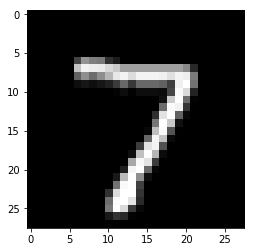

In [57]:
print(X_test[0])
print(X[0])
plt.imshow(np.reshape(X[0], [28, 28]), cmap='gray')
plt.show()

In [ ]:
(X_train, y_train), (X_test, y_test) = mn.load_data()
X_test = X_test.astype('float32')

f = open("shift2.txt", 'w')
(X_train, y_train), (X_test, y_test) = mn.load_data()
X_test = X_test.astype('float32')
n_images = 10000
datagen = ImageDataGenerator()# fit parameters from data
val = 0.0
while val<4:
    transform_parameters = { 'tx': val}
    
    X = datagen.apply_transform(X_test, transform_parameters)
    X_test = X
    x_te={'images': X_test}
    input_fn = tf.estimator.inputs.numpy_input_fn(
        x=x_te, shuffle=False)
    # Use the model to predict the images class
    preds = list(model.predict(input_fn))
    accuracy = 0.0
    # Display
    for i in range(n_images):
        if (preds[i] == y_test[i]):
            accuracy = accuracy + 1/n_images
#         plt.imshow(np.reshape(X_test[i], [28, 28]), cmap='gray')
#         plt.show()
#         print("Model prediction:", preds[i])
    print("Model accuracy:", accuracy)
    f.write(str(val)+"\t"+str(accuracy)+"\n")
    val = val-0.2
f.close()
print("Transformation completed!")




In [ ]:
print(X[0])